In [1]:
import sys
sys.path
sys.path.append('/home/mnt/nzh/nzhanglab/project/shuang/miniconda3/envs/scglue2/lib/python3.8/site-packages')


In [2]:
import anndata
import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns
from matplotlib import rcParams

In [3]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [5]:
rna = anndata.read_h5ad("pbmc/rna_preprocessed_v2.h5ad")
atac = anndata.read_h5ad("pbmc/atac_preprocessed_v2.h5ad")
graph = nx.read_graphml("pbmc/prior_v2.graphml.gz")

In [6]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)

In [7]:
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [8]:
graph = graph.subgraph(itertools.chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
))

In [9]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, graph,
    fit_kws={"directory": "pbmc_glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] SCGLUEModel: Setting `graph_batch_size` = 13247
[INFO] SCGLUEModel: Setting `max_epochs` = 220
[INFO] SCGLUEModel: Setting `patience` = 19
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 10
[INFO] SCGLUETrainer: Using training directory: "pbmc_glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.508, 'g_kl': 0.014, 'g_elbo': 0.522, 'x_rna_nll': 0.378, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.389, 'x_atac_nll': 0.259, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.261, 'dsc_loss': 0.686, 'vae_loss': 0.67, 'gen_loss': 0.636}, val={'g_nll': 0.502, 'g_kl': 0.014, 'g_elbo': 0.516, 'x_rna_nll': 0.38, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.39, 'x_atac_nll': 0.256, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.258, 'dsc_loss': 0.687, 'vae_loss': 0.669, 'gen_loss': 0.635}, 2.9s elapsed
[INFO] SCGLUETrainer: [Epoch 20] train={'g_nll': 0.479, 'g_kl': 0.014, 'g_elbo': 0.493, 'x_rna_nll': 0.372, 'x_rna_kl

2022-06-28 17:03:53,023 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "63"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (17, 24)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 13247
[INFO] SCGLUEModel: Setting `align_burnin` = 37
[INFO] SCGLUEModel: Setting `max_epochs` = 220
[INFO] SCGLUEModel: Setting `patience` = 19
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 10
[INFO] SCGLUETrainer: Using training directory: "pbmc_glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.459, 'g_kl': 0.014, 'g_elbo': 0.473, 'x_rna_nll': 0.369, 'x_rna_kl': 0.01, 'x_rna_elbo': 0.379, 'x_atac_nll': 0.251, 'x_atac_kl': 0.002, 'x_atac_elbo': 0.253, 'dsc_loss': 0.69, 'vae_loss': 0.651, 'gen_loss': 0.617}, val={'g_nll': 0.457, 'g_

2022-06-28 17:11:30,230 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "108"...


In [11]:
glue.save("pbmc_glue_v2.dill")

In [12]:
glue = scglue.models.load_model("pbmc_glue_v2.dill")

In [13]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, graph,
    count_layers={"rna": "counts"}
)
dx

[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


,n_meta,consistency
0,10,0.458789
1,20,0.415978
2,50,0.386990
3,100,0.360956
4,200,0.309761


In [14]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

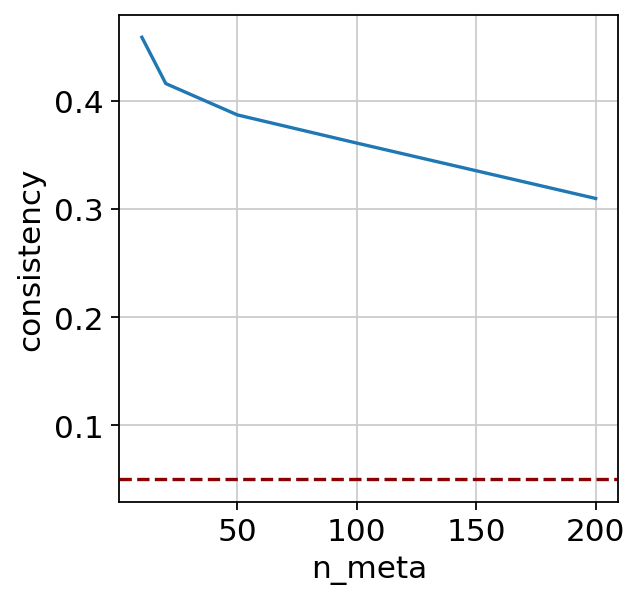

In [15]:
_ = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")


In [16]:
import numpy
rna.obs_names = numpy.char.add("rna",rna.obs_names)
atac.obs_names = numpy.char.add("atac",atac.obs_names)

In [17]:
combined = anndata.concat([rna, atac])


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [18]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["cell_type", "domain"], wspace=0.65)

/home/stat/shuang91/gpuenv385/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'domain' as categorical


KeyError: 'Could not find key cell_type in .var_names or .obs.columns.'

<Figure size 1056x320 with 0 Axes>

In [ ]:
feature_embeddings = glue.encode_graph(graph)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

In [ ]:
glue_array = combined.obsm['X_glue']
import numpy as np
glue_array = pd.DataFrame(glue_array)
glue_array.index = np.concatenate([rna.obs_names,atac.obs_names])

In [13]:
glue_array.to_csv('/home/mnt/nzh/nzhanglab/project/shuang/scATAC/comparison_methods/scglue/pbmc_glue_embeddings_v2.csv', index=True)

In [14]:
glue_array.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15580 entries, rnaAAACAGCC to atacTTTGTTGG
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       15580 non-null  float32
 1   1       15580 non-null  float32
 2   2       15580 non-null  float32
 3   3       15580 non-null  float32
 4   4       15580 non-null  float32
 5   5       15580 non-null  float32
 6   6       15580 non-null  float32
 7   7       15580 non-null  float32
 8   8       15580 non-null  float32
 9   9       15580 non-null  float32
 10  10      15580 non-null  float32
 11  11      15580 non-null  float32
 12  12      15580 non-null  float32
 13  13      15580 non-null  float32
 14  14      15580 non-null  float32
 15  15      15580 non-null  float32
 16  16      15580 non-null  float32
 17  17      15580 non-null  float32
 18  18      15580 non-null  float32
 19  19      15580 non-null  float32
 20  20      15580 non-null  float32
 21  21      15580 non-null 